In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Choose sample and chrom

In [5]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"



# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [147]:
%%time

def do_it_all(focal_sample_id, denovo_chrom):

    #
    # 1. Get mismatches
    #
    high_confidence_snp_slack = 10

    events_df = pl.scan_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.read_refinement.parquet"
    )

    events_df = (events_df
        .with_columns(
            ((pl.col("op1") != pl.col("op2")) & (pl.col("op1").is_in([7,8]) & pl.col("op2").is_in([7,8])) & (pl.col("length") == 1)).alias("is_snp"),
            ((pl.col("op1") == pl.col("op2")) & (pl.col("op1").is_in([8]) & pl.col("op2").is_in([8])) & (pl.col("length") == 1)).alias("is_two_sided_mismatch")
        )
    )

    # Find high confidence SNPs
    high_confidence_snps = (events_df
        .filter(pl.col("is_snp") | pl.col("is_two_sided_mismatch"))
        .join(
            (events_df
                .select(["op1", "op2", "length", "read_name", "start", "end"])
                .filter((pl.col("op1") == pl.col("op2")) & (pl.col("op1") == 7) & (pl.col("length") >= high_confidence_snp_slack))
            ),
            left_on=["start", "read_name"],
            right_on=["end", "read_name"],
        )
        .join(
            events_df.filter(pl.col("length") == 0),        
            left_on=["start", "read_name"],
            right_on=["end", "read_name"],
            how="anti",
        )
        .drop(["op1_right", "op2_right", "length_right", "start_right"])
        .join(
            (events_df
                .select(["op1", "op2", "length", "read_name", "start", "end"])
                .filter((pl.col("op1") == pl.col("op2")) & (pl.col("op1") == 7) & (pl.col("length") >= high_confidence_snp_slack))
            ),
            left_on=["end", "read_name"],
            right_on=["start", "read_name"],
        )
        .join(
            events_df.filter(pl.col("length") == 0),        
            left_on=["end", "read_name"],
            right_on=["start", "read_name"],
            how="anti",
        )
        .select(["read_name", "start", "end"])
        .with_columns(pl.lit(True).alias("is_high_conf_mismatch"))
    )

    high_conf_mismatches_df = (events_df
        .join(high_confidence_snps, on=["read_name", "start", "end"])
    )

    high_conf_mismatches_df = high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 2. Filter TRs and low-complexity
    root_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm")
    scaffolds_path = root_path / "02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds"
    hap_scaffolds_path = root_path / "01.data/05.ragtag/03.haplotype_specific_scaffolds"

    filtered_high_conf_mismatches_df = diagnostics.add_tandem_repeat_finder_annotation(
        # add this fake field to make it work
        high_conf_mismatches_df.with_columns(pl.lit(True).alias("is_high_conf_snp")),
        hap_scaffolds_path \
                / f"{focal_sample_id}" / "haplotype_1" / f"ragtag.scaffold.expanded.fasta.{denovo_chrom}.trf.dat",
        hap_scaffolds_path \
                / f"{focal_sample_id}" / "haplotype_2" / f"ragtag.scaffold.expanded.fasta.{denovo_chrom}.trf.dat",
    )

    filtered_high_conf_mismatches_df = diagnostics.add_sdust_annotation(
        filtered_high_conf_mismatches_df,
        hap_scaffolds_path \
                / f"{focal_sample_id}" / "haplotype_1" / f"ragtag.scaffold.expanded.fasta.{denovo_chrom}.sdust.tsv",
        hap_scaffolds_path \
                / f"{focal_sample_id}" / "haplotype_2" / f"ragtag.scaffold.expanded.fasta.{denovo_chrom}.sdust.tsv",
    )

    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )

    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_snp")

    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect()
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 1

    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
            ),
        ]
    )

    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "op2"])
        .count()
        .pivot(
            values=['count'],
            index=['qual_rounded'],
            columns=['op2'],
            aggregate_function='sum'
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10.3 µs


# Get them all

In [149]:
%%time 
dfs = []
for chrom in aut_chrom_names:
    print(chrom)
    dfs.append(do_it_all(focal_sample_id, chrom + "_RagTag"))

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
CPU times: user 39min 33s, sys: 15min 6s, total: 54min 39s
Wall time: 26min 24s


# Plot it all

In [171]:
%%time
putative_gc_df_hap_cnt = pl.concat(dfs[15:16]).group_by(["qual_rounded"]).agg(pl.col("7").sum(), pl.col("8").sum())

CPU times: user 957 µs, sys: 374 µs, total: 1.33 ms
Wall time: 729 µs


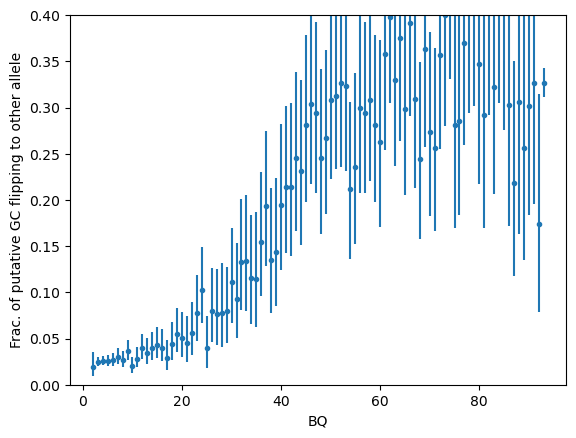

In [172]:
import statsmodels.stats.proportion

p = putative_gc_df_hap_cnt["7"] / (putative_gc_df_hap_cnt["7"] + putative_gc_df_hap_cnt["8"])
lo, hi = statsmodels.stats.proportion.proportion_confint(putative_gc_df_hap_cnt["7"], (putative_gc_df_hap_cnt["7"] + putative_gc_df_hap_cnt["8"]), method="beta", alpha=0.05)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
plt.ylim(0,0.4);


In [96]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=100):
    display(putative_gc_df_hap.filter(pl.col("qual_start1") == 93))

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,is_forward1,is_forward2,read_length1,read_length2,mapq1,mapq2,qual_start1,qual_start2,is_snp,is_two_sided_mismatch,is_high_conf_mismatch,is_high_conf_snp,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,fits1,fits2,fits1_before,fits1_after,fits2_before,fits2_after
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,bool,i32,i32,i32,i32,u8,u8,bool,bool,bool,bool,i64,f64,i64,f64,i32,i32,i64,i64,i64,i64,i64,i64
3084,3085,1,8,8,205316680,205316681,1,205021574,205021575,1,10,36,"""m64174e_220620_110709/18286182/ccs""",true,true,14067,14067,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,13,26,0,0
1790,1791,1,8,8,27255682,27255683,1,26736112,26736113,1,3,5,"""m64174e_220620_110709/179045797/ccs""",true,true,14841,14841,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,1,6,0,0
7194,7195,1,8,8,14164713,14164714,1,13651095,13651096,1,11,25,"""m64094e_220717_002414/51185215/ccs""",true,true,10971,10971,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,7,5,0,0
849,850,1,8,8,187823914,187823915,1,187590598,187590599,1,1,3,"""m64094e_220715_151527/122487380/ccs""",true,true,6408,6408,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,1,3,0,0
7974,7975,1,8,8,37690887,37690888,1,37138618,37138619,1,5,29,"""m64094e_220715_151527/24120125/ccs""",true,true,17380,17380,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,9,4,0,0
12130,12131,1,8,8,81100849,81100850,1,79973513,79973514,1,7,15,"""m64174e_220620_110709/64424188/ccs""",true,true,14038,14038,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,2,2,0,0
5248,5249,1,8,8,235512610,235512611,1,234960716,234960717,1,3,23,"""m64094e_220715_151527/132317198/ccs""",true,true,10887,10887,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,1,8,0,0
3800,3801,1,8,8,46540554,46540555,1,45855236,45855237,1,5,13,"""m64094e_220717_002414/72482991/ccs""",true,true,6212,6212,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,4,1,0,0
4863,4864,1,8,8,210415955,210415956,1,210143543,210143544,1,5,23,"""m64174e_220620_110709/46336105/ccs""",true,true,19277,19277,60,60,93,93,false,true,true,true,0,0.0,0,0.0,0,0,0,0,8,12,0,0
